# 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [6]:
dfcc = pd.read_excel(os.getenv("HOME")+'/ryancompton.net/assets/culver_city/responsive_record.xlsx')

In [7]:
dftax = pd.read_sql("SELECT * FROM culver_city_rental_tax;", engine)

In [14]:
dfcc['AddressLineSum'] = dfcc['AddressLine1'].map(str) + ", " + dfcc['AddressLine2'].map(str)
print(dfcc.columns)
dfcc.sample(3)

Index(['AddressLine1', 'AddressLine2', 'OwnerName', 'CertOfOccuDate',
       'YearBuilt', 'UnitNumb', 'UnitStatusDescription', 'NumofBeds',
       'NumOfBaths', 'EmcumberedUnit', 'ReportDate', 'RentAmount',
       'AddressLineSum'],
      dtype='object')


AddressLine1                AddressLine2          OwnerName  \
26842  10951  WESTWOOD BLVD    CULVER CITY, CA 90230-4947        LESTER CHEW   
24647       4335  ELENDA ST    CULVER CITY, CA 90230-4131  HERBERT GREENBERG   
47759       3427 CAROLINE AVE  CULVER CITY, CA 90232-7454         JIM DUTTON   

            CertOfOccuDate  YearBuilt UnitNumb UnitStatusDescription  \
26842  1995-03-01 00:00:00     1940.0        1                Rented   
24647  2018-02-02 00:00:00     1942.0        1                Rented   
47759  1954-01-01 00:00:00     1954.0        5                Rented   

       NumofBeds  NumOfBaths EmcumberedUnit ReportDate  RentAmount  \
26842        2.0         1.5             NO 2022-03-24      3850.0   
24647        3.0         1.0             NO 2020-04-18      4325.0   
47759        2.0         1.0             NO 2022-06-22      2795.0   

                                          AddressLineSum  
26842  10951  WESTWOOD BLVD  , CULVER CITY, CA 90230-...  
24647      4335  ELENDA ST  , CULVER CITY, CA 90230-4131  
47759      3427 CAROLINE AVE, CULVER CITY, CA 90232-7454

In [82]:
dfm = pd.merge(dfcc, dftax, on='AddressLineSum').copy()
print(dfm.shape)
print(dfm.UseType.value_counts())

dfm = dfm.dropna()
dfm = dfm[dfm.SqftMain != '']
dfm.RentAmount = dfm.RentAmount.map(int)
dfm = dfm[dfm['RentAmount'] > 0]
dfm['ReportDate'] = pd.to_datetime(dfm['ReportDate'])
dfm['CurrentRoll_BaseYear'] = pd.to_datetime(dfm['CurrentRoll_BaseYear'])
dfm['BaseValue_Year'] = pd.to_datetime(dfm['BaseValue_Year'])
dfm = dfm[dfm['BaseValue_Year'] < dfm['ReportDate']]
print(dfm.shape)
dfm.SqftMain = dfm.SqftMain.map(float)
dfm['MaxRentAmount'] = dfm.groupby('AddressLineSum')['RentAmount'].transform('max')
dfm['MinRentAmount'] = dfm.groupby('AddressLineSum')['RentAmount'].transform('min')
dfm = dfm[[
    'RentAmount',
    'MaxRentAmount',
    'MinRentAmount',
    'ReportDate',
    'AddressLineSum',
    'AIN',
    'CurrentRoll_BaseYear',
    'BaseValue_Year',
    'CurrentRoll_LandValue',
    'CurrentRoll_ImpValue',
    'UseType',
    'CertOfOccuDate',
    'SqftMain',
]]
dfm = dfm.drop_duplicates()

dfm["years_held"] = (dfm["CurrentRoll_BaseYear"] - dfm["BaseValue_Year"]).map(lambda x: pd.to_numeric(x.days/365.2425))
dfm['current_assessment']  = dfm.CurrentRoll_LandValue.map(int) + dfm.CurrentRoll_ImpValue.map(int)
dfm['max_rent_per_sqft'] = dfm.MaxRentAmount/dfm.SqftMain
dfm['min_rent_per_sqft'] = dfm.MinRentAmount/dfm.SqftMain
dfm['rent_per_sqft'] = dfm.RentAmount/dfm.SqftMain
dfm['assessment_per_sqft'] = dfm.current_assessment/dfm.SqftMain
dfm["lagov"] = "https://portal.assessor.lacounty.gov/parceldetail/" + dfm["AIN"]

dfm = dfm[dfm.UseType.map(lambda x: x in {'Single Family Residence', 'Condominium'})]
print(dfm.shape)

(62227, 44)
UseType
Multi-Family Residence     23704
Condominium                 7003
Single Family Residence     4864
Vacant Land                  554
Commercial                   448
Other Property Type            2
Name: count, dtype: int64
(30872, 44)
(3357, 20)


In [47]:
dfm.sample()

MaxRentAmount  MinRentAmount ReportDate  \
44933           2258           1458 2020-04-03   

                                       AddressLineSum         AIN  \
44933  3945  TILDEN AVE  , CULVER CITY, CA 90232-3964  4213006038   

      CurrentRoll_BaseYear BaseValue_Year CurrentRoll_LandValue  \
44933           2023-01-01     1986-01-01                433476   

      CurrentRoll_ImpValue                 UseType       CertOfOccuDate  \
44933               260835  Multi-Family Residence  2012-08-01 00:00:00   

       SqftMain  years_held  current_assessment  max_rent_per_sqft  \
44933    3898.0          37              694311           0.579271   

       min_rent_per_sqft  assessment_per_sqft  \
44933           0.374038           178.119805   

                                                   lagov  
44933  https://portal.assessor.lacounty.gov/parceldet...

In [80]:
dfm['AddressLineSum'].unique().shape

(1023,)

/Users/arachnotron/.virtualenvs/prop13ipnb/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


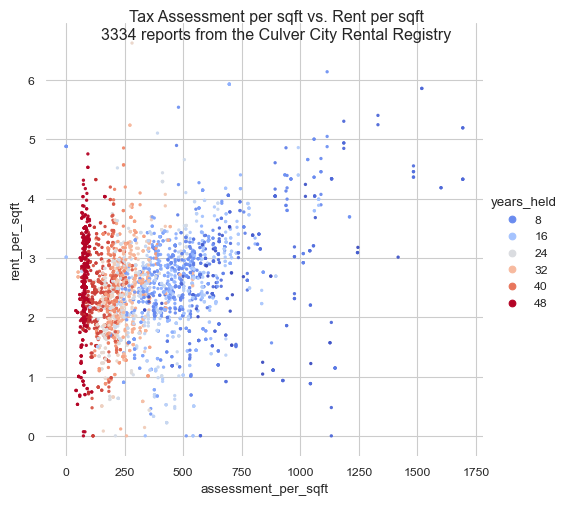

In [86]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

dfm = dfm[dfm.assessment_per_sqft < 1750]
dfm = dfm[dfm.max_rent_per_sqft < 7.5]

g = sns.relplot(
    data=dfm,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.95,
    palette=cmap,
    marker=".",
)
g.despine(left=True, bottom=True)
plt.suptitle(
    f"Tax Assessment per sqft vs. Rent per sqft\n{len(dfm)} reports from the Culver City Rental Registry",
    y=1.0,
)
plt.savefig(
   os.path.join(
       os.environ["HOME"], "prop13wtf/assets/pix/tax_vs_rent_culver_city.png"
   )
)

In [52]:
sns.displot(dfm['max_rent_per_sqft'] - dfm['min_rent_per_sqft'])

AttributeError: 'float' object has no attribute 'days'

<Axes: ylabel='Count'>

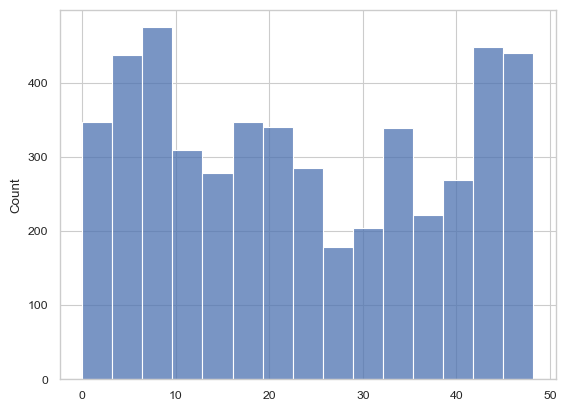

In [56]:
sns.histplot((dfm['ReportDate'] - dfm['BaseValue_Year']).map(lambda x: pd.to_numeric(x.days/365.2425)))

/Users/arachnotron/.virtualenvs/prop13ipnb/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


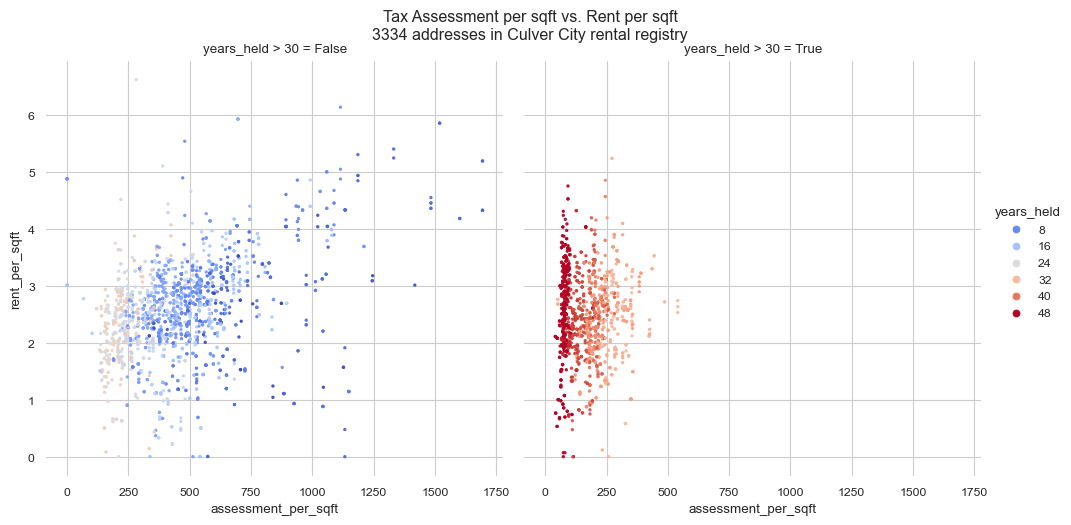

In [78]:
dfm['years_held > 30'] = dfm.years_held > 30
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)

g = sns.relplot(
    data=dfm,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.95,
    palette=cmap,
    marker=".",
    col='years_held > 30'
)
g.despine(left=True, bottom=True)
plt.suptitle(
    f"Tax Assessment per sqft vs. Rent per sqft\n{len(dfm)} addresses in Culver City rental registry",
    y=1.04,
)
plt.savefig(
   os.path.join(
       os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_culver_city_split30.png"
   )
)



In [83]:
hex_cmap = sns.color_palette("coolwarm", n_colors=len(set(df.years_held))).as_hex()


def get_color(x):
    for idx, years in enumerate(sorted(set(df.years_held))):
        if x == years:
            return hex_cmap[max(0, idx)]


df["gmap_color"] = df["years_held"].map(get_color)

df["assessment_to_rent_ratio"] = df["assessment_to_rent_ratio"].round(2)
dfp = df[
    [
        "glat",
        "glng",
        "gmap_color",
        "gaddress",
        "current_rent",
        "current_assessment",
        "assessment_to_rent_ratio",
        "BaseValue_Year",
        "lagov",
        "screenshot",
    ]
]
print(dfp.sample(10).to_csv(sep="\t", index=False))

NameError: name 'df' is not defined

In [ ]:
dfp.to_csv(
    "/home/ryn/ryancompton.net/assets/taxrentlocations.tsv", sep="\t", index=False
)